In [1]:
import json, glob, os, numpy
from data_process_functions_lili_original import *
os.chdir("/Users/adamyedidia/breast_cancer/spreadsheets/")

import openpyxl, pprint


SHEET_NAME = 'manisha_new.xlsx'
#LIST_OF_BINARY_COLS = ['Q', 'R', 'S', 'T','U','V','W','X','Y','Z','AA','AB','AC']
LIST_OF_BINARY_COLS = ['D','F','G','H','I','J','K','L','M','T','U','W','X','Y','AA','AE','AH','AJ']
LIST_OF_REAL_COLS = ['A','C','N','O','P','Q','R','S','V','Z','U','V','Z']  
ANSWER_COL = 'AQ'
        
data,feature_names,result=dataprocess(SHEET_NAME,LIST_OF_BINARY_COLS,LIST_OF_REAL_COLS,ANSWER_COL)
yy=[1 if x=='M' else 0 for x in result]
print 'cancer numbers: %d' %yy.count(1)
y=np.array(yy)
X_structure=data[:,1:]
feature_names_structure=feature_names[1:]
n=X_structure.shape[0]


def readreport(SHEET_NAME):
    sheet = openpyxl.load_workbook(SHEET_NAME).active
    report=[]
    for j in range (1,sheet.max_column+1):
        if sheet.cell(row=1,column=j).value=='BXPATHREP':
            for i in range(2,sheet.max_row+1):
                rpt=sheet.cell(row=i,column=j).value
                #print rpt
                #rpt.replace('_x000D_\n_x000D_\n', '\n')
                rpt=rpt.replace('_x000D_\n_x000D_\n', '')
                rpt=rpt.replace('MASSACHUSETTS GENERAL HOSPITAL','')
                rpt=rpt.replace('BOSTON, MA  REMOVED_CASE_ID','')
                rpt=rpt.lower()
                rpt=rpt.replace('removed_patient_name','')
                rpt=rpt.replace('_patient_name_removed','')
                rpt=rpt.replace('removed_accession_id','')
                rpt=rpt.replace('removed_case_id','')
                rpt=rpt.replace('removed_date','')
                rpt=rpt.replace('removed_month','')
                rpt=rpt.replace('removed_patient_','')
                rpt=rpt.replace('\n\n','')  
                rpt=rpt.replace('\n \n','')
                rpt.strip('\n\n')
                rpt.strip('\n \n')
                report.append(rpt)
    return report

report= readreport(SHEET_NAME)
vectorizer = CountVectorizer(ngram_range=(1, 2),min_df=1)
#XXX = vectorizer.fit_transform(report)
ft_report= numpy.array(vectorizer.fit_transform(report).toarray())

feature_names_report = vectorizer.get_feature_names()
feature_names_report=np.array(feature_names_report,dtype=str)
print "total uni & bi gram features are :%s" %str(feature_names_report.shape)
count=numpy.sum(ft_report,axis=0)
delete=[]
thresh=20             #####################===============you can change this guy
for i in range(1,count.shape[0]):
    if count[i]<thresh:
        delete.append(i)
ft_report_p=numpy.delete(ft_report,delete,1)
feature_names_report_prune=numpy.delete(feature_names_report,delete,0)
print "total uni & bi gram features pruned with threshold of 20  are  :%s" %str(feature_names_report_prune.shape)
ft_report_prune=ft_report_p

Real-valued Features:
ID
AGE
WEIGHT
HEIGHT
BIRTH
AGEPREG
MAAGE
MPAGE
DENSITY
PRIORBX
ASSESS
DENSITY
PRIORBX

Binary Features:
RACE
LOC
SPROCS
FBC
PBC
POC
SMOKE
ALCOHOL
ASHKENAZI
HORMONE
ASSESS
FIRSTMAM
FROMSCREEN
CLINFIND
FINDTYPE
SIDE
BXTYPE
BXPATH_CONCAT

Result:
SXRESULT
data size is: 1119 X 157
test reasult is: SXRESULT
cancer numbers: 135
total uni & bi gram features are :(43867,)
total uni & bi gram features pruned with threshold of 20  are  :(2303,)


In [2]:
ft_report_prune.shape

(1118, 2303)

In [3]:
ft_report_prune.shape

(1118, 2303)

In [4]:
f_structure= ExtraTreesClassifier(n_estimators=200,max_depth=12,max_features=80,class_weight = {1:7},
                              random_state=123)
f_report = ExtraTreesClassifier(n_estimators=200,max_depth=10,max_features=500,class_weight = {1:5},
                              random_state=123)
'''
feature_ranking(f_structure,feature_names_structure,X_structure,y,'importantfeature_structure.txt',pp=1)
feature_ranking(f_report,feature_names_report_prune,ft_report_prune,y,'importantfeature_report.txt',pp=1)
'''

"\nfeature_ranking(f_structure,feature_names_structure,X_structure,y,'importantfeature_structure.txt',pp=1)\nfeature_ranking(f_report,feature_names_report_prune,ft_report_prune,y,'importantfeature_report.txt',pp=1)\n"

In [5]:
from sklearn.cross_validation import StratifiedShuffleSplit

n_str=100
n_report=180
weight =3
random_state= 127

#sss = StratifiedShuffleSplit(y, 10, test_size=0.05, random_state=1237)
#rs = cross_validation.ShuffleSplit(len(y), n_iter=10,test_size=.1, random_state=1237)

from sklearn.cross_validation import StratifiedKFold
skf = StratifiedKFold(y, 10, shuffle=True, random_state=random_state)

k=0

YTEST=[]
YTEST_index=[]
Probability=[]

for train_index, test_index in skf: 
        ff = ExtraTreesClassifier(n_estimators=200,max_depth=10,max_features=100
                                      ,class_weight = {1:weight},random_state=123)
        
        print 'new sets'
        X_train_struct, X_test_struct = X_structure[train_index], X_structure[test_index]
        X_train_txt, X_test_txt = ft_report_prune[train_index], ft_report_prune[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        YTEST.append(y_test)
        YTEST_index.append(test_index)
   
        #k+=1
        #feature_ranking(f_structure,feature_names_structure,X_train_struct,y_train,'importantfeature_strcture_'+str(k)+'.txt',pp=0)
        #feature_ranking(f_report,feature_names_report_prune,X_train_txt,y_train,'importantfeature_report_'+str(k)+'.txt',pp=0)

        indx_structure=get_sorted_ft_idx(f_structure,X_train_struct,y_train,n=n_str)
        indx_txt=get_sorted_ft_idx(f_report,X_train_txt,y_train,n=n_report)
        
        X_train=np.concatenate((X_train_struct[:,indx_structure], X_train_txt[:,indx_txt]), axis=1)
        X_test=np.concatenate((X_test_struct[:,indx_structure], X_test_txt[:,indx_txt]), axis=1)
        
       
        ff.fit(X_train, y_train)

        ff_proba=ff.predict_proba(X_test)
        Probability.append(ff_proba)
        indx1=np.where(y_test==1)
        indx2=np.where(y_test==0)
        yy= np.random.random_sample((len(y_test),))
        plt.clf()
        #plt.scatter([0, 1], [0, 1])
        plt.scatter(ff_proba[:,1][indx1], yy[indx1], c=y_test[indx1], s=50,marker='o')
        plt.scatter(ff_proba[:,1][indx2], yy[indx2], c=y_test[indx2], s=50,marker='+',label='no')
        plt.xlabel('probability')
        plt.ylabel('Random number')
        plt.legend(loc='best')
        plt.show()
        #prb=cus_probability(threshold, ff_proba[:,1])
        #prb=np.array(prb)

new sets
new sets
new sets
new sets
new sets
new sets
new sets
new sets
new sets
new sets


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


In [83]:
p_all=[]
f_all=[]
r_all=[]
roc_all=[]
patients=[]
for ii in range(len(YTEST)):
    y_test=YTEST[ii]
    ff_proba=Probability[ii]
    roc=[]
    p=[]
    r=[]
    f=[]
    #results=[]
    pat=[]
    Thresh=[]
    for i in range(30):
        threshold=float(float(i+1)/80)
        Thresh.append(threshold)
        predicted=cus_predict(threshold, ff_proba[:,1])
        #results.append(predicted)

        fpr_rf, tpr_rf, _ = roc_curve(y_test,predicted)
        roc.append([fpr_rf, tpr_rf])
        p.append(precision_score(y_test,predicted))
        r.append(recall_score(y_test,predicted))
        f.append(f1_score(y_test,predicted))
        print(classification_report(y_test,predicted) )
        print 'roc_auc is %f :' %roc_auc_score(y_test,predicted)
        pt=len(predicted)-np.count_nonzero(predicted)
        print 'non cancer patient : %d' %pt
        pat.append(pt)

    #plt.scatter(prb[:,1],y_test)

    '''
    indxFb=np.intersect1d(np.where(ff_proba[:,1]>0.7 ),np.where(y_test==0))
    indxFm=np.intersect1d(np.where(ff_proba[:,1]<0.3),np.where(y_test==1))
    fp= X_test[indxFm][:,0]  ### The first column is the patient ID
    fn=X_test[indxFb][:,0]
    falsepositive.extend(fp)
    falsenegative.extend(fn)
    '''
    p_all.append(p)
    r_all.append(r)
    f_all.append(f)
    roc_all.append(roc)
    patients.append(pat)

             precision    recall  f1-score   support

          0       1.00      0.27      0.42        60
          1       0.15      1.00      0.27         8

avg / total       0.90      0.35      0.40        68

roc_auc is 0.633333 :
non cancer patient : 16
             precision    recall  f1-score   support

          0       1.00      0.28      0.44        60
          1       0.16      1.00      0.27         8

avg / total       0.90      0.37      0.42        68

roc_auc is 0.641667 :
non cancer patient : 17
             precision    recall  f1-score   support

          0       1.00      0.32      0.48        60
          1       0.16      1.00      0.28         8

avg / total       0.90      0.40      0.46        68

roc_auc is 0.658333 :
non cancer patient : 19
             precision    recall  f1-score   support

          0       1.00      0.42      0.59        60
          1       0.19      1.00      0.31         8

avg / total       0.90      0.49      0.56        68

ro

In [84]:
n=2
#m=f_all.shape[1]
m=10

f_all=np.array(f_all)
r_all=np.array(r_all)
patients=np.array(patients)
print 'trainging size: %d' %f_all[:-n,i].shape
for i in range(m):
    print average(f_all[:-n,i])
print "  \n test result"
for i in range(m):
    print average(f_all[-n:,i])
print " \n train result"
for i in range(m):
    print average(r_all[:-n,i])
print "  \ntest result"

for i in range(m):
    print average(r_all[-n:,i])

print "\n train result"
t=sum([len(l) for l in YTEST_index[:-n] ])
for i in range(m):
    print float(sum(patients[:-n,i])/float(sum([len(l) for l in YTEST_index[:-n] ])))

print ' \n test result'
for i in range(m):
    print float(sum(patients[-n:,i])/float(sum([len(l) for l in YTEST_index[-n:] ])))
    
patients[9,3]

trainging size: 8
0.239362509963
0.248916679186
0.268146963709
0.291208364449
0.322062600434
0.346616941295
0.355921374459
0.370199535566
0.389706781844
0.383767094974
  
 test result
0.250319284802
0.259615384615
0.272173913043
0.277173913043
0.260351673284
0.281771501926
0.303474903475
0.333333333333
0.354838709677
0.381481481481
 
 train result
0.966517857143
0.930803571429
0.930803571429
0.912946428571
0.912946428571
0.897321428571
0.866071428571
0.832589285714
0.814732142857
0.732142857143
  
test result
1.0
1.0
0.928571428571
0.928571428571
0.785714285714
0.785714285714
0.785714285714
0.785714285714
0.785714285714
0.785714285714

 train result
0.203738317757
0.269158878505
0.330841121495
0.405607476636
0.471028037383
0.52523364486
0.560747663551
0.6
0.629906542056
0.671028037383
 
 test result
0.257575757576
0.287878787879
0.378787878788
0.393939393939
0.469696969697
0.507575757576
0.560606060606
0.606060606061
0.636363636364
0.674242424242


27

In [71]:
#[54486, 86819,111803]
TestID=54486
newdata=[]
newtxt=[]
ID=[]
newy=[]
for i in range(data.shape[0]):
    if data[i,0] ==TestID:
        ID.append(data[i,0])
        newdata.append(data[i,1:])
        newtxt.append(ft_report_p[i,:])
        newy.append(y[i])
    '''
    else:
        if yy[i]==1:
            ID.append(data[i,0])
            newdata.append(data[i])
            newtxt.append(ft_report_p[i,:])
            newy.append(yy[i])
    '''
newdata=np.array(newdata)
newtxt=np.array(newtxt)
newy=np.array(newy)

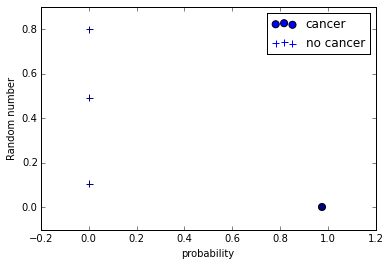

In [87]:
X_test_special=np.concatenate((newdata[:,indx_structure], newtxt[:,indx_txt]), axis=1)
ff_proba=ff.predict_proba(X_test_special)
Probability.append(ff_proba)
indx1=np.where(newy==1)
indx2=np.where(newy==0)
yy= np.random.random_sample((len(newy),))
plt.clf()
#plt.scatter([0, 1], [0, 1])
plt.scatter(ff_proba[:,1][indx1], yy[indx1], c=newy[indx1], s=50,marker='o',label='cancer')
plt.scatter(ff_proba[:,1][indx2], yy[indx2], c=newy[indx2], s=50,marker='+',label='no cancer')
plt.xlabel('probability')
plt.ylabel('Random number')
plt.legend(loc='best')
plt.show()
#prb=cus_probability(threshold, ff_proba[:,1])
#prb=np.array(prb)

In [52]:
print str(X_test.shape)
print len( indx_structure)
print len( indx_txt)

(66L, 280L)
100
180
